# IMPORTING PACKAGES AND LOADING THE DATA

In [4]:
# Importing needed libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK tools for text processing
import re, nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import LatentDirichletAllocation as LDA
pd.set_option('display.max_colwidth',-1)


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [5]:
## Uncomment and run the codes below to install language translator and have a view at the supported languages.
# pip install google_trans_new
# import google_trans_new
# print(google_trans_new.LANGUAGES)

# Special Portuguese stemmer package but this was not helpful when I used it.
#nltk.download('rslp')
#stemmer = nltk.stem.RSLPStemmer()

In [6]:
# Running an example of google translate(from portuguese to english), Data Connnection is required.
from google_trans_new import google_translator
translator = google_translator()
translate_text = translator.translate('Excelente mochila, entrega super rápida.',lang_tgt='en',lang_src='pt' )
print(translate_text)

Excellent backpack, super fast delivery. 


In [7]:
# Reading in the reviews dataset
review_df = pd.read_csv('olist_order_reviews_dataset.csv')
review_df.head()
review_df.shape

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01 00:00:00,2018-03-02 10:26:53


(100000, 7)

In [8]:
# We have missing values in the reviews and their titles
review_df.isnull().sum()

review_id                  0    
order_id                   0    
review_score               0    
review_comment_title       88285
review_comment_message     58247
review_creation_date       0    
review_answer_timestamp    0    
dtype: int64

# DATA PREPROCESSING

#### To deal with these missing values, we would seperate the reviews and the titles and drop the missing rows seperately so that we don't have unequal shapes of rows.

In [9]:
review_data_title = review_df['review_comment_title']
review_data = review_df.drop(['review_comment_title'],axis=1)


In [10]:
# Dropping NaN values
review_data  = review_data.dropna()
review_data_title = review_data_title.dropna()


In [11]:
# Resetting the reviews index and visualizing the data
review_data = review_data.reset_index(drop=True)
review_data.head(3)
review_data.shape

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01 00:00:00,2018-03-02 10:26:53
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho,2018-05-22 00:00:00,2018-05-23 16:45:47


(41753, 6)

In [12]:
# Resetting the reviews titles index and visualizing the data
review_data_title = review_data_title.reset_index(drop=True)
review_data_title.head(3)
review_data_title.shape

0    recomendo              
1    Super recomendo        
2    Não chegou meu produto 
Name: review_comment_title, dtype: object

(11715,)

In [13]:
# List of Portuguese stopwords to be used( Uncomment to see)
#stopwords.words('portuguese')

#### In the next cell, we would transform the reviews data by removing stopwords, using regular expressions module to accept only letters, tokenize those words and then make all the words lower case for consistency.

In [13]:
 comments = []
stop_words = set(stopwords.words('portuguese'))


for words in review_data['review_comment_message']:
    only_letters = re.sub("[^a-zA-Z]", " ",words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    comments.append(' '.join(filtered_result))

In [14]:
# Visualizing the cleaned reviews data(uncomment to see)
#comments

# TOPIC MODELLING WITH LDA

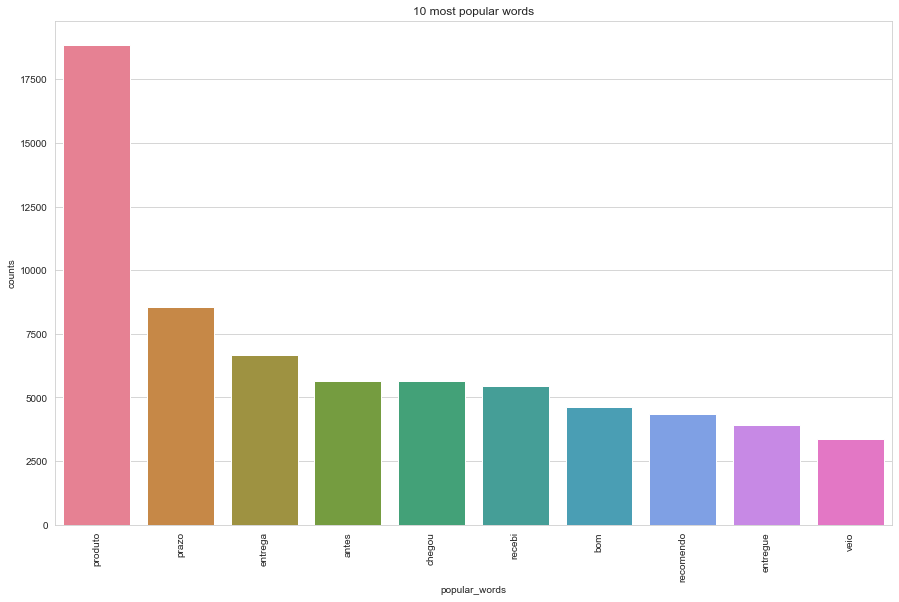

In [15]:
# Loading the library with the CountVectorizer method
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most popular words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('popular_words')
    plt.ylabel('counts')
    plt.show()
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(comments)# Fit and transform the processed words
plot_10_most_common_words(count_data, count_vectorizer)# Visualising the 10 most popular words


In [17]:
def print_top_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

number_topics = 12 # Printing top 12 topics
number_words = 10
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)# Print the topics generated by the LDA model
print("LDA GENERATED TOPICS:")
print_top_topics(lda, count_vectorizer, number_words)

LatentDirichletAllocation(n_components=12, n_jobs=-1)

LDA GENERATED TOPICS:

Topic #0:
bom recomendo produto pre demorou todos pouco cor achei mto

Topic #1:
comprar sempre loja lannister rel gio vel produtos compro site

Topic #2:
produto entrega correios ter problemas demora loja entregue problema es

Topic #3:
gostei fiquei satisfeita satisfeito produto compra bastante obrigado pel primeira

Topic #4:
produto qualidade bem veio caixa embalagem tima ser ncia material

Topic #5:
entrega pida produto super parab ns recomendo data compra qualidade

Topic #6:
prazo antes produto chegou bem entregue entrega dentro recomendo previsto

Topic #7:
produto tudo excelente timo conforme certo recomendo chegou perfeito pido

Topic #8:
recebi produto ainda at comprei dia entregue nao agora produtos

Topic #9:
produto compra recebi quero dias pedido pra dinheiro comprei fiz

Topic #10:
comprei recebi veio nota ok dois apenas duas fiscal chegou

Topic #11:
produto veio boa otimo ainda qualidade defeito frete casa correio


In [19]:
# Translating the topics
Lda_model = pd.DataFrame({'Model_Topics':['bom recomendo produto pre demorou todos pouco cor achei mto','comprar sempre loja lannister rel gio vel produtos compro site','produto entrega correios ter problemas demora loja entregue problema es','gostei fiquei satisfeita satisfeito produto compra bastante obrigado pel primeira','produto qualidade bem veio caixa embalagem tima ser ncia material','entrega pida produto super parab ns recomendo data compra qualidade','prazo antes produto chegou bem entregue entrega dentro recomendo previsto','produto tudo excelente timo conforme certo recomendo chegou perfeito pido','recebi produto ainda at comprei dia entregue nao agora produtos','produto compra recebi quero dias pedido pra dinheiro comprei fiz','comprei recebi veio nota ok dois apenas duas fiscal chegou','produto veio boa otimo ainda qualidade defeito frete casa correio']})
Lda_model['Translation'] = Lda_model['Model_Topics'].apply(translator.translate) 
Lda_model

,Model_Topics,Translation
0,bom recomendo produto pre demorou todos pouco cor achei mto,good recommend product pre took all little color I found a lot
1,comprar sempre loja lannister rel gio vel produtos compro site,always buy lannister store watch products buy site
2,produto entrega correios ter problemas demora loja entregue problema es,product delivery couriers having problems delay store delivered problem es
3,gostei fiquei satisfeita satisfeito produto compra bastante obrigado pel primeira,I liked it I was satisfied satisfied product purchase thank you very much for the first
4,produto qualidade bem veio caixa embalagem tima ser ncia material,product quality well came box packaging great be material
5,entrega pida produto super parab ns recomendo data compra qualidade,fast delivery super congratulations product we recommend date purchase quality
6,prazo antes produto chegou bem entregue entrega dentro recomendo previsto,deadline before product arrived well delivered delivery within recommend expected
7,produto tudo excelente timo conforme certo recomendo chegou perfeito pido,product all excellent great as sure recommend arrived perfect pido
8,recebi produto ainda at comprei dia entregue nao agora produtos,I still received product until I bought it
9,produto compra recebi quero dias pedido pra dinheiro comprei fiz,product purchase I received I want days request for money I bought I did


We can now see the popular topics that are made by customers. 
Topic 2 talked about having delivery problems or deliveries made late
Topic 3 talked about the great quality of the delivered goods
Topic 6 talked about the product arriving before deadline
 So far, there has been lots of positive comments made by customers.

## Performing similar operations on review titles

In [21]:
 comments1 = []
stop_words = set(stopwords.words('portuguese'))


for words in review_data_title:
    only_letters = re.sub("[^a-zA-Z]", " ",words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    comments1.append(' '.join(filtered_result))

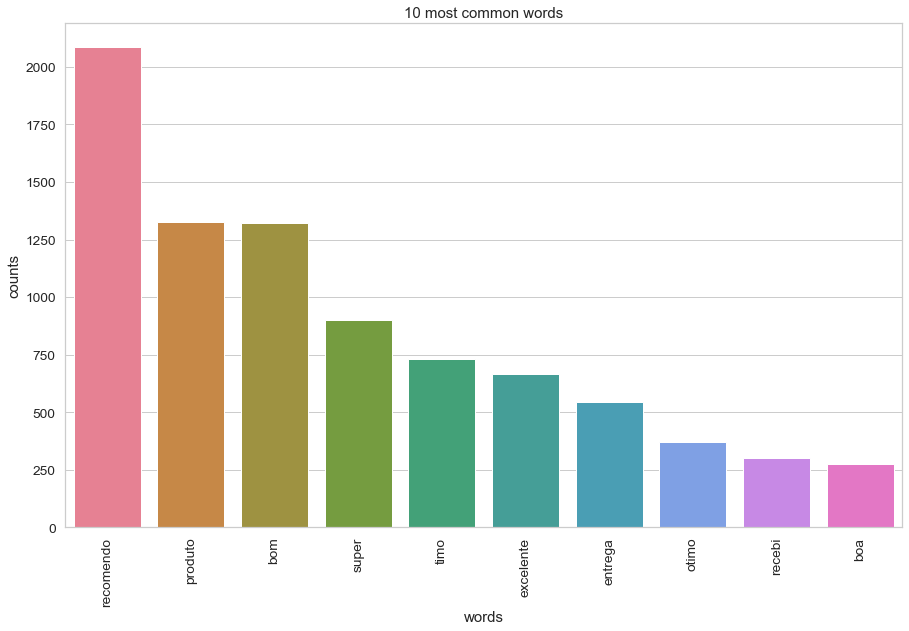

In [22]:
# Load the library with the CountVectorizer method
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer()# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(comments1)# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)


In [23]:
# Helper function
def print_top_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 12
number_words = 10# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)# Print the topics found by the LDA model
print("LDA GENERATED TOPICS:")
print_top_topics(lda, count_vectorizer, number_words)

LatentDirichletAllocation(n_components=12, n_jobs=-1)

LDA GENERATED TOPICS:

Topic #0:
prazo chegou antes regular pessimo todos faltou demora site certeza

Topic #1:
ssimo top avalia sempre lannister linda bem falso kit mochila

Topic #2:
produto defeito vel faltando veio rapido dez confi melhor zero

Topic #3:
boa otima entrega atraso lindo satisfa original relogio decep recebimento

Topic #4:
tudo perfeito ruim produto certo ssima diferente rapidez servi estrelas

Topic #5:
recomendo super amei sim recebido incorreto recomend razo divergente indico

Topic #6:
entrega atendimento falta vendedor rapida errada produtos ncia incompleta cor

Topic #7:
produto timo recomendado errado parab ns funciona show veio pre

Topic #8:
tima loja qualidade pido maravilhoso recomento comprei ria devolu erro

Topic #9:
recebi produto entregue compra nao ainda pedido adorei incompleto mercadoria

Topic #10:
excelente entrega pida gostei nota satisfeito satisfeita gio rel perfeita

Topic #11:
bom otimo ok bonito aprovado mt aten esperava restri enganado


In [20]:
pd.options.display.max_colwidth = 100

Lda_model = pd.DataFrame({'Titles_Model_Topics':['prazo chegou antes regular pessimo todos faltou demora site certeza','ssimo top avalia sempre lannister linda bem falso kit mochila','produto defeito vel faltando veio rapido dez confi melhor zero','boa otima entrega atraso lindo satisfa original relogio decep recebimento','tudo perfeito ruim produto certo ssima diferente rapidez servi estrelas','recomendo super amei sim recebido incorreto recomend razo divergente indico','entrega atendimento falta vendedor rapida errada produtos ncia incompleta cor','produto timo recomendado errado parab ns funciona show veio pre','tima loja qualidade pido maravilhoso recomento comprei ria devolu erro','recebi produto entregue compra nao ainda pedido adorei incompleto mercadoria','excelente entrega pida gostei nota satisfeito satisfeita gio rel perfeita','bom otimo ok bonito aprovado mt aten esperava restri enganado']})
Lda_model['Translation'] = Lda_model['Titles_Model_Topics'].apply(translator.translate) 
Lda_model

# ML generated topics

,Titles_Model_Topics,Translation
0,prazo chegou antes regular pessimo todos faltou demora site certeza,deadline arrived before regular pessimo all missed delay site sure
1,ssimo top avalia sempre lannister linda bem falso kit mochila,ssimo top always evaluates lannister beautiful and fake kit backpack
2,produto defeito vel faltando veio rapido dez confi melhor zero,missing defect product came fast ten trusted best zero
3,boa otima entrega atraso lindo satisfa original relogio decep recebimento,good great delivery delay beautiful satisfies original watch disappoint receipt
4,tudo perfeito ruim produto certo ssima diferente rapidez servi estrelas,everything perfect bad product right very different speed service stars
5,recomendo super amei sim recebido incorreto recomend razo divergente indico,recommend super loved yes received incorrect recomend reason divergent
6,entrega atendimento falta vendedor rapida errada produtos ncia incompleta cor,delivery service missing seller fast wrong products incomplete color
7,produto timo recomendado errado parab ns funciona show veio pre,optimum product recommended wrong for we work shows came pre
8,tima loja qualidade pido maravilhoso recomento comprei ria devolu erro,great store quality pido wonderful recommend buy back error
9,recebi produto entregue compra nao ainda pedido adorei incompleto mercadoria,received product delivered purchase not yet ordered loved incomplete merchandise


From what can be seen above, there are also negative topics made by customers.